<a href="https://colab.research.google.com/github/akkiyolo/pytorch/blob/main/Handwritten_Digits_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Handwritten digits prediction (MNIST Dataset used)
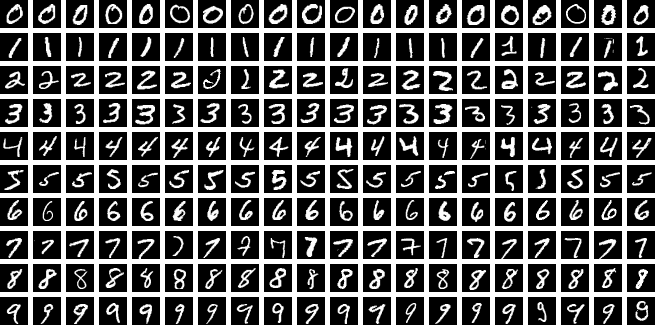

#### A complete deep learning project for recognizing handwritten digits using Convolutional Neural Networks.

In [1]:
## Importring required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu126
CUDA Available: False
Using device: cpu


#### Set Random Seeds for Reproducibility

In [2]:
## Set Random Seeds for Reproducibility
''' like for example :
Same results every time

(Without seed)
Run 1: 98.5% accuracy
Run 2: 98.9% accuracy
Run 3: 98.2% accuracy
(With seed)
Run 1: 98.7% accuracy
Run 2: 98.7% accuracy
Run 3: 98.7% accuracy
'''
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

#### Load and Prepare the Dataset

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of batches (train): {len(train_loader)}")
print(f"Number of batches (test): {len(test_loader)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.47MB/s]

Training samples: 60000
Test samples: 10000
Number of batches (train): 938
Number of batches (test): 157


#### Visualize Sample Images

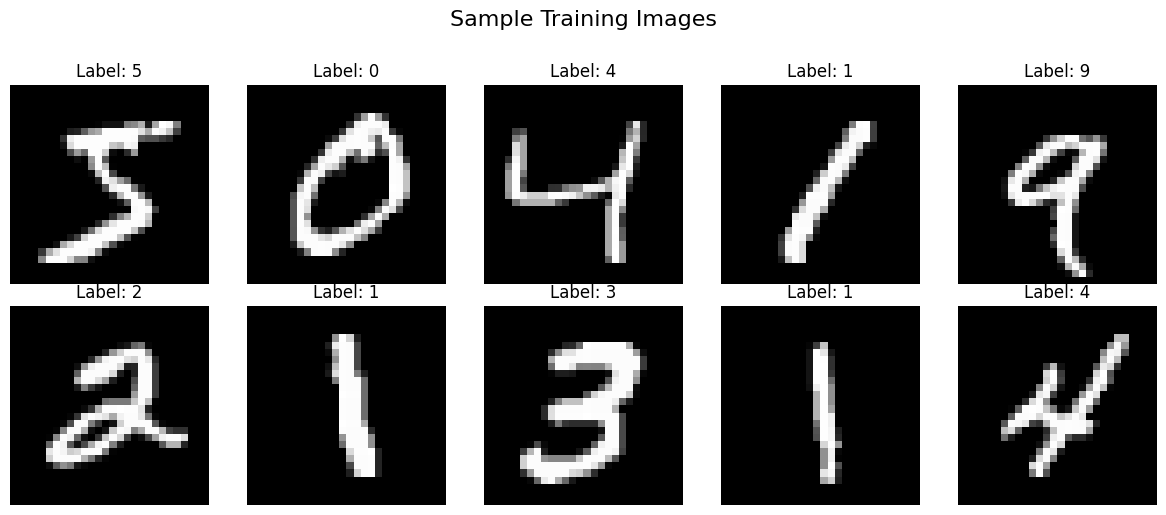

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.suptitle("Sample Training Images", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### Define the CNN model architecture

In [5]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14

        # Conv block 2
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7

        # Conv block 3
        x = self.pool(F.relu(self.conv3(x)))  # 7x7 -> 3x3

        # Flatten
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Initialize model
model = DigitCNN().to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total Parameters: 422,026
Trainable Parameters: 422,026


#### Define Loss Function and Optimizer

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional but recommended)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("Loss Function: CrossEntropyLoss")
print("Optimizer: Adam")
print(f"Initial Learning Rate: {optimizer.param_groups[0]['lr']}")

Loss Function: CrossEntropyLoss
Optimizer: Adam
Initial Learning Rate: 0.001


#### Training function

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # Print progress
        if (batch_idx + 1) % 200 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.6f}')

    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

#### Test function

In [8]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Statistics
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total

    print(f'\nTest set: Average loss: {avg_loss:.4f}, '
          f'Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')

    return avg_loss, accuracy

#### Model training

In [9]:
num_epochs = 10

# Lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...\n")

for epoch in range(1, num_epochs + 1):
    print(f"{'='*60}")
    print(f"EPOCH {epoch}/{num_epochs}")
    print(f"{'='*60}")

    # Train
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Test
    test_loss, test_acc = test(model, device, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Learning rate scheduling
    scheduler.step(test_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\n✅ Training completed!")

Starting training...

EPOCH 1/10
Epoch: 1 [12736/60000 (21%)]	Loss: 0.128471
Epoch: 1 [25536/60000 (43%)]	Loss: 0.186393
Epoch: 1 [38336/60000 (64%)]	Loss: 0.058451
Epoch: 1 [51136/60000 (85%)]	Loss: 0.098585

Test set: Average loss: 0.0462, Accuracy: 9857/10000 (98.57%)

Train Loss: 0.2777, Train Acc: 91.11%
Test Loss: 0.0462, Test Acc: 98.57%
EPOCH 2/10
Epoch: 2 [12736/60000 (21%)]	Loss: 0.108476
Epoch: 2 [25536/60000 (43%)]	Loss: 0.023549
Epoch: 2 [38336/60000 (64%)]	Loss: 0.113454
Epoch: 2 [51136/60000 (85%)]	Loss: 0.093431

Test set: Average loss: 0.0323, Accuracy: 9906/10000 (99.06%)

Train Loss: 0.0777, Train Acc: 97.91%
Test Loss: 0.0323, Test Acc: 99.06%
EPOCH 3/10
Epoch: 3 [12736/60000 (21%)]	Loss: 0.009498
Epoch: 3 [25536/60000 (43%)]	Loss: 0.069774
Epoch: 3 [38336/60000 (64%)]	Loss: 0.003825
Epoch: 3 [51136/60000 (85%)]	Loss: 0.010174

Test set: Average loss: 0.0303, Accuracy: 9916/10000 (99.16%)

Train Loss: 0.0583, Train Acc: 98.45%
Test Loss: 0.0303, Test Acc: 99.16%
EPO

#### Plot Training history

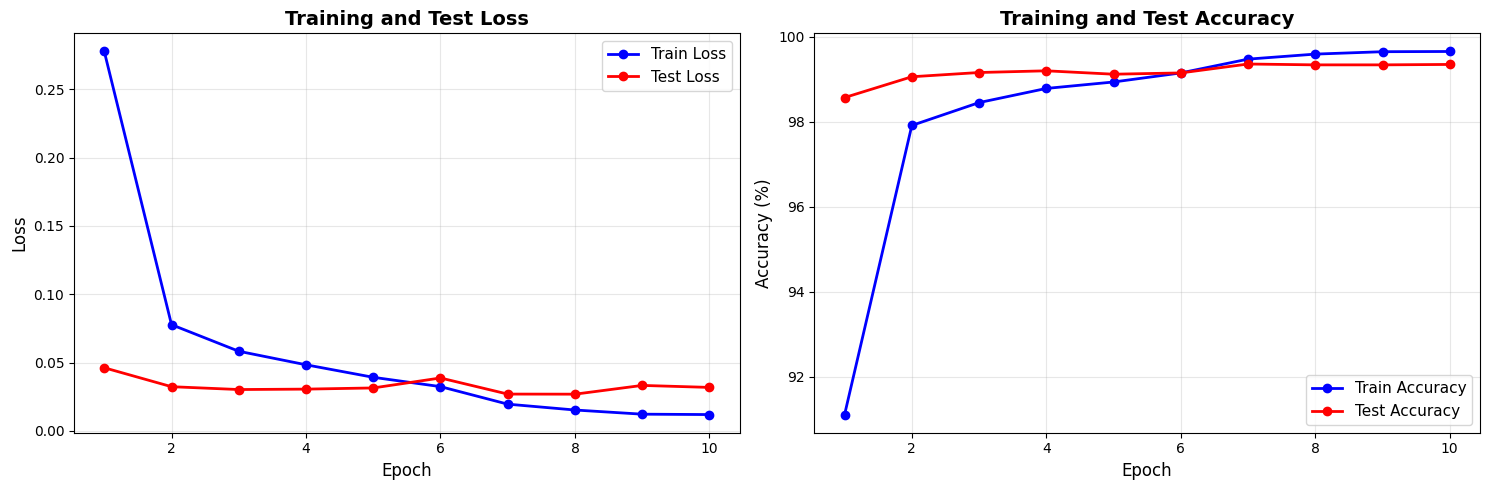

Final Test Accuracy: 99.35%


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(range(1, num_epochs + 1), train_losses, 'bo-', label='Train Loss', linewidth=2)
ax1.plot(range(1, num_epochs + 1), test_losses, 'ro-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot Accuracy
ax2.plot(range(1, num_epochs + 1), train_accuracies, 'bo-', label='Train Accuracy', linewidth=2)
ax2.plot(range(1, num_epochs + 1), test_accuracies, 'ro-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

#### Generate Predictions for Confusion Matrix

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = output.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Predictions generated for all test samples!")

Predictions generated for all test samples!


#### Confusion matrix

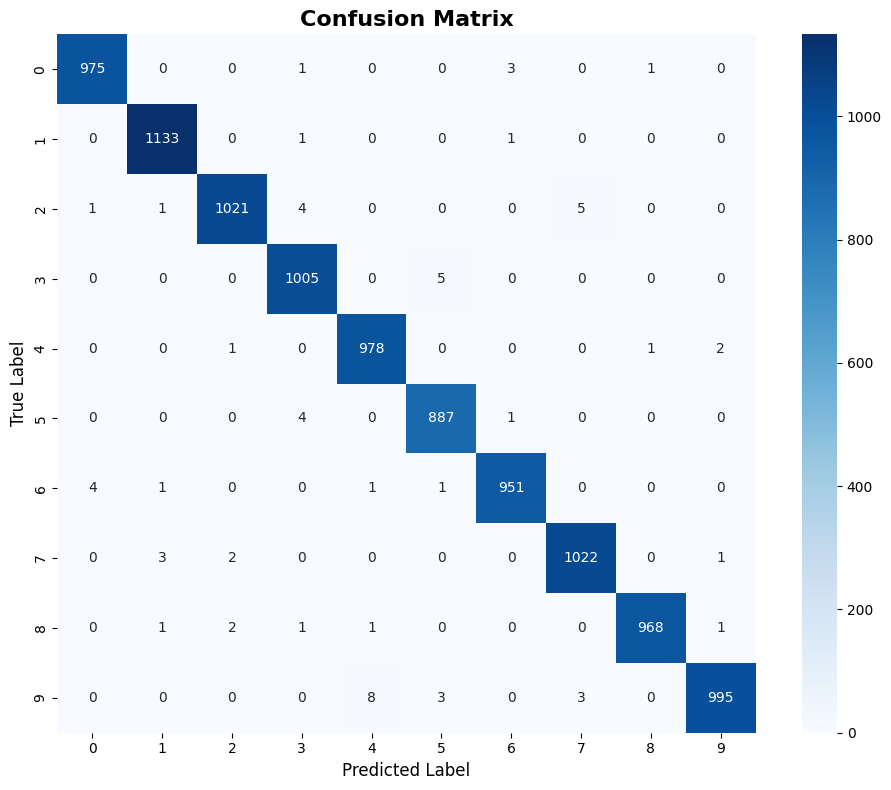


Per-class Accuracy:
Digit 0: 99.49%
Digit 1: 99.82%
Digit 2: 98.93%
Digit 3: 99.50%
Digit 4: 99.59%
Digit 5: 99.44%
Digit 6: 99.27%
Digit 7: 99.42%
Digit 8: 99.38%
Digit 9: 98.61%


In [12]:
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print per-class accuracy
print("\nPer-class Accuracy:")
for i in range(10):
    class_acc = cm[i, i] / cm[i].sum() * 100
    print(f"Digit {i}: {class_acc:.2f}%")

#### Classification Report

In [13]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds,
                          target_names=[str(i) for i in range(10)]))

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

